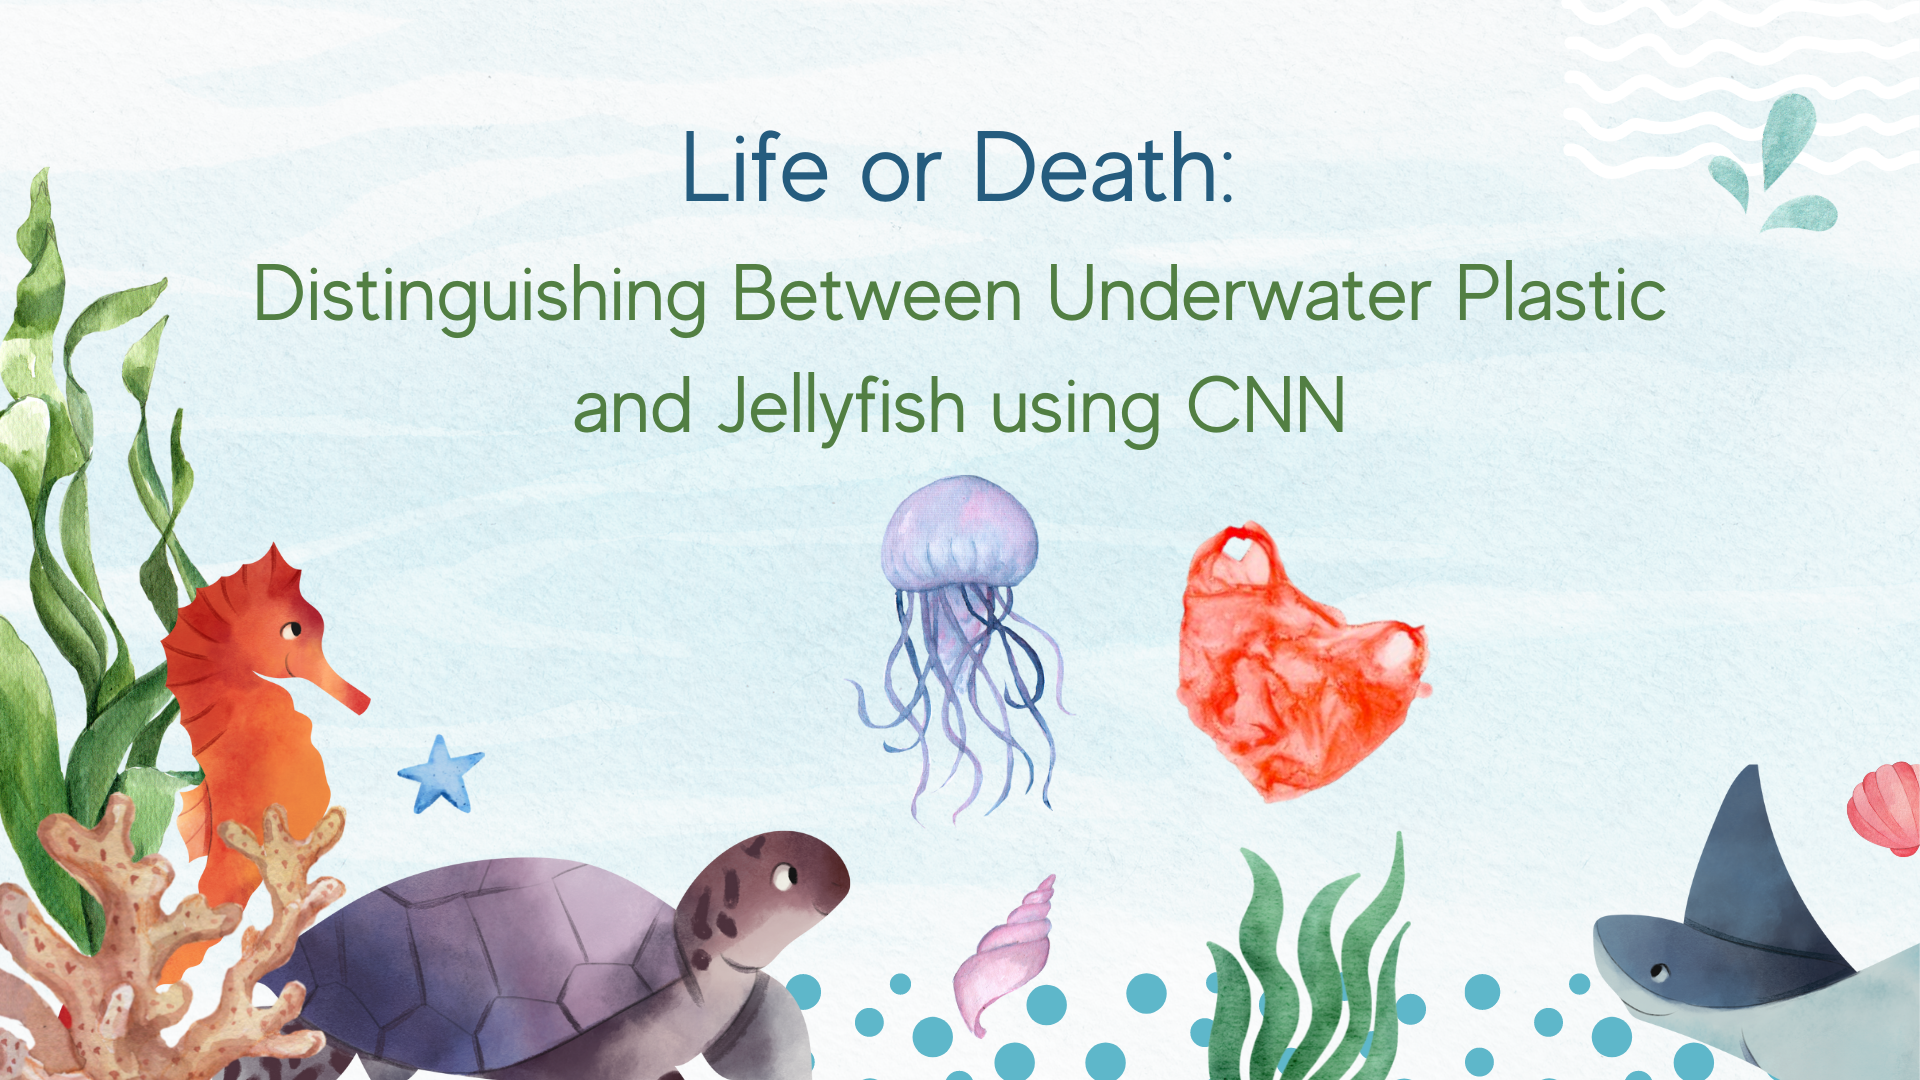

# Objective
The urgency of solving the ocean plastic pollution problem is of no question, and now may be the only opportunity we have to join this fight before its too late. Researchers all over the world have been doubling down on how to automatically collect plastic waste in the ocean, with some papers exploring the use of autonomous underwater vehicles for trash detection and removal. [1]

But this brings up the question: If an animal like a sea turtle can’t even tell the difference between a plastic bag and food like jellyfish, can AI?

In order to safely clean the ecosystem, we need to be able to properly distinguish between plastic litter and other marine life that resembles it. [2] The project explores this by using pretrained models to do image classification on a jellyfish vs underwater plastic dataset.

# Methodology

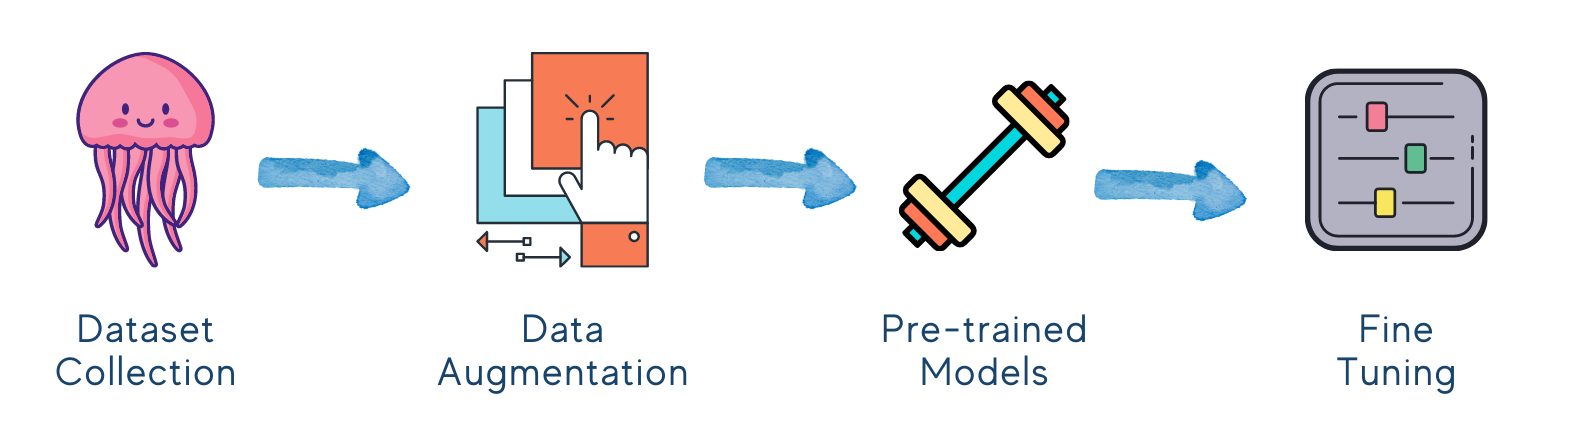

1. **Dataset Collection**: A dataset of underwater plastic and jellyfish needed to be collected. The underwater plastic images used for this project were taken from a project called DeepPlastic [3], and 1960 images were used. The jellyfish images used were collected from `zenodo` [4] and `images.cv` [5], and 1960 images were used.
2. **Data Augmentation**: Data augmentation was done by creating synthetic data from the existing image dataset. This is to increase regularization and reduce overfitting. Various techniques were chosen below to distort the images, zoom in, shift the image and flip the image.
3. **Pre-trained Models**: Pretrained models were used for the image classification, namely, VGG16 and ResNet50. VGG16 is a simple and widely used CNN architecture due to its uniform architecture with 16 convolutional layers. ResNet50 is a variant of the ResNet model, and it has 48 Convolutional layers along with 1 Max Pooling layer and 1 Average Pooling layer. It uses residual connections between layers, which uses the concept of adding the original input to the output of a series of layer operations. It uses “linear shortcuts” that connect the input to an addition operation at the bottom of the model. These pretrained models were added as a base to a classifier composed of a Flattening layer, Dense layer with a `relu` activation function, a Batch Normalization layer, a Dropout layer and a Dense layer with a sigmoid activation function. The models was run first without fine tuning.
4. **Fine-tuning**: Both models were then fine tuned, which involved unfreezing different layers for each model. For VGG16, the model was fine tuned by unfreezing the top block of the architecture. For ResNet50, the model was fine tuned by first unfreezing the top 1 block, then by unfreezing the top 2 blocks, and lastly by unfreezing the top 3 blocks.

# Loading the Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from tensorflow.keras import layers, models, optimizers
from keras.models import Sequential

import glob, os, random
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-1dntfr6o because the default path (/home/mbaluyut/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# access data
base_path = 'plastic_vs_jellyfish/dataset'
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))
print(len(img_list))

3920


In [3]:
# define plotting function
def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    # plot accuracy 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    ax1.plot(epochs, acc, 'ko', label='Training accuracy')
    ax1.plot(epochs, val_acc, 'k', label='Validation accuracy')
    ax1.set_title('Training and Validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.legend()

    # plot loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    ax2.plot(epochs, loss, 'ro', label='Training loss')
    ax2.plot(epochs, val_loss, 'r', label='Validation loss')
    ax2.set_title('Training and Validation loss')
    ax2.set_xlabel('Epochs')
    ax2.legend()

# VGG16

In [4]:
# instantiate model
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

2022-03-12 01:31:50.241987: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-12 01:32:12.531512: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10419 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [5]:
# add as base model
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,813,377
Trainable params: 16,812,865
Non-trainable params: 512
__________________________________________

In [6]:
# freezing the base
print('This is the number of trainable weights before freezing the conv base:',
      len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable weights after freezing the conv base:',
      len(model.trainable_weights))

model.summary()

This is the number of trainable weights before freezing the conv base: 32
This is the number of trainable weights after freezing the conv base: 6
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)    

## VGG16: Data Augmentation

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1 # ma
)
  
train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(150, 150), # could be this
    batch_size=75,
    class_mode='binary',
    subset='training',
    seed=0
)
 
test_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.1) # remove

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(150, 150),
    batch_size=75,
    class_mode='binary',
    subset='validation',
    seed=0
)

Found 3528 images belonging to 2 classes.
Found 392 images belonging to 2 classes.


## VGG16: No Fine Tuning

In [8]:
# run model
model.compile(loss='binary_crossentropy',
   optimizer='adam',
   metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=25,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

2022-03-12 01:32:15.101506: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-03-12 01:32:17.398743: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2022-03-12 01:32:17.920227: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-12 01:32:17.921103: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-12 01:32:17.921158: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-03-12 01:32:17.922400: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-12 01:32:17.922555: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


48/48 [==============================] - 71s 1s/step - loss: 0.3294 - accuracy: 0.8676 - val_loss: 0.6670 - val_accuracy: 0.7857
Epoch 2/25
48/48 [==============================] - 33s 693ms/step - loss: 0.1984 - accuracy: 0.9240 - val_loss: 0.5415 - val_accuracy: 0.7959
Epoch 3/25
48/48 [==============================] - 32s 660ms/step - loss: 0.1929 - accuracy: 0.9252 - val_loss: 0.6235 - val_accuracy: 0.8444
Epoch 4/25
48/48 [==============================] - 33s 689ms/step - loss: 0.1884 - accuracy: 0.9283 - val_loss: 0.5338 - val_accuracy: 0.8495
Epoch 5/25
48/48 [==============================] - 32s 661ms/step - loss: 0.1542 - accuracy: 0.9425 - val_loss: 0.5952 - val_accuracy: 0.8571
Epoch 6/25
48/48 [==============================] - 33s 685ms/step - loss: 0.1479 - accuracy: 0.9425 - val_loss: 0.9045 - val_accuracy: 0.7653
Epoch 7/25
48/48 [==============================] - 32s 657ms/step - loss: 0.1506 - accuracy: 0.9459 - val_loss: 0.5883 - val_accuracy: 0.8495
Epoch 8/25
48

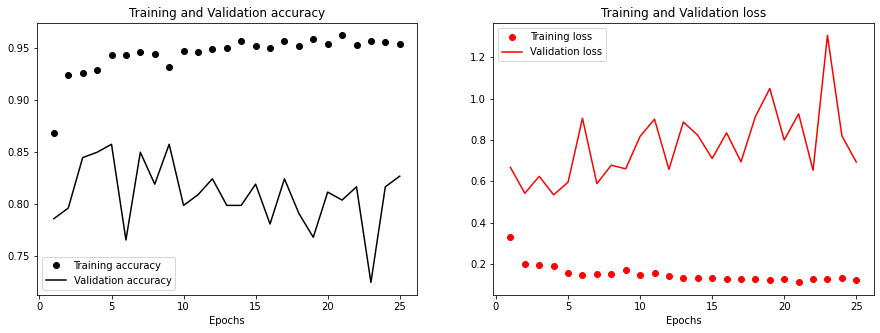

In [9]:
# vgg16 no fine tuning
plot_results(history)

## VGG16: Unfreeze top 1 block

In [10]:
# freezing all layers except top block
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

/home/msds2022/mbaluyut/.conda/envs/msds2022-ml3/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
48/48 [==============================] - 34s 652ms/step - loss: 0.2559 - accuracy: 0.9065 - val_loss: 1.1203 - val_accuracy: 0.8214
Epoch 2/25
48/48 [==============================] - 31s 648ms/step - loss: 0.1592 - accuracy: 0.9402 - val_loss: 2.0404 - val_accuracy: 0.6709
Epoch 3/25
48/48 [==============================] - 31s 648ms/step - loss: 0.1587 - accuracy: 0.9410 - val_loss: 24.4221 - val_accuracy: 0.5000
Epoch 4/25
48/48 [==============================] - 32s 659ms/step - loss: 0.1597 - accuracy: 0.9416 - val_loss: 3.0259 - val_accuracy: 0.5332
Epoch 5/25
48/48 [==============================] - 32s 660ms/step - loss: 0.1108 - accuracy: 0.9569 - val_loss: 1.3446 - val_accuracy: 0.7092
Epoch 6/25
48/48 [==============================] - 32s 659ms/step - loss: 0.0831 - accuracy: 0.9714 - val_loss: 0.9220 - val_accuracy: 0.8367
Epoch 7/25
48/48 [==============================] - 32s 654ms/step - loss: 0.0953 - accuracy: 0.9660 - val_loss: 2.6343 - val_accuracy: 0.645

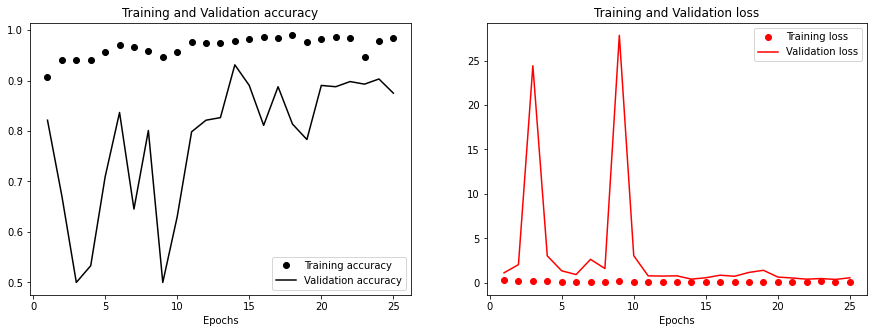

In [11]:
# run model
model.compile(loss='binary_crossentropy',
   optimizer='adam',
   metrics=['accuracy'])

history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=25,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        max_queue_size=30,
)

plot_results(history)

# ResNet50

In [39]:
# instantiate the model
res_model = ResNet50(include_top=False,
                     weights='imagenet',
                     input_shape=(150,150,3))

res_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [40]:
# add as base model
model = models.Sequential()
model.add(res_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               13107456  
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 36,696,449
Trainable params: 36,642,817
Non-trainable params: 53,632
_____________________________________

In [41]:
# freezing the base
print('This is the number of trainable weights before freezing the conv base:',
      len(model.trainable_weights))

res_model.trainable = False

print('This is the number of trainable weights after freezing the conv base:',
      len(model.trainable_weights))

model.summary()

This is the number of trainable weights before freezing the conv base: 218
This is the number of trainable weights after freezing the conv base: 6
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               13107456  
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1) 

## ResNet50: Data Augmentation

In [42]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1 # ma
)
  
train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(150, 150), # could be this
    batch_size=75,
    class_mode='binary',
    subset='training',
    seed=0
)
 
test_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.1) # remove

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(150, 150),
    batch_size=75,
    class_mode='binary',
    subset='validation',
    seed=0
)

Found 3528 images belonging to 2 classes.
Found 392 images belonging to 2 classes.


## ResNet50: No Fine Tuning

In [28]:
model.compile(loss='binary_crossentropy',
   optimizer='adam',
   metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=25,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/25
48/48 [==============================] - 38s 723ms/step - loss: 0.5765 - accuracy: 0.7333 - val_loss: 0.6534 - val_accuracy: 0.6709
Epoch 2/25
48/48 [==============================] - 33s 675ms/step - loss: 0.4660 - accuracy: 0.7948 - val_loss: 1.9498 - val_accuracy: 0.5000
Epoch 3/25
48/48 [==============================] - 32s 660ms/step - loss: 0.4317 - accuracy: 0.8138 - val_loss: 1.7509 - val_accuracy: 0.5000
Epoch 4/25
48/48 [==============================] - 32s 672ms/step - loss: 0.4305 - accuracy: 0.8152 - val_loss: 3.1809 - val_accuracy: 0.5000
Epoch 5/25
48/48 [==============================] - 33s 682ms/step - loss: 0.4096 - accuracy: 0.8291 - val_loss: 0.5909 - val_accuracy: 0.7015
Epoch 6/25
48/48 [==============================] - 32s 656ms/step - loss: 0.4170 - accuracy: 0.8282 - val_loss: 4.7010 - val_accuracy: 0.5000
Epoch 7/25
48/48 [==============================] - 32s 663ms/step - loss: 0.4040 - accuracy: 0.8220 - val_loss: 5.9272 - val_accuracy: 0.5000

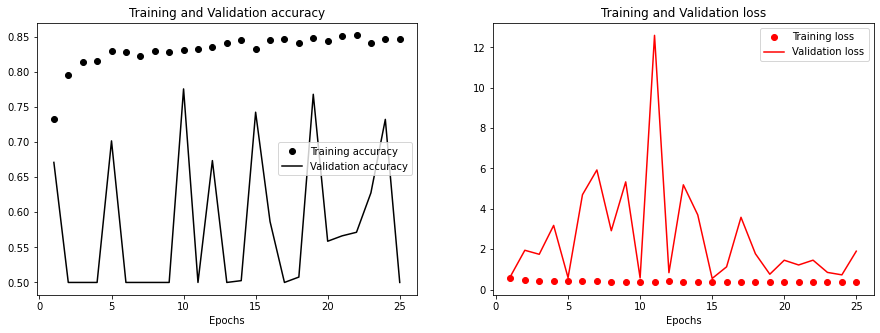

In [29]:
plot_results(history)

## ResNet50: Unfreeze top 1 block

In [43]:
# unfreeze
for layer in res_model.layers[:165]:
    layer.trainable = False
for layer in res_model.layers[165:]:
    layer.trainable = True

In [31]:
# run model
model.compile(loss='binary_crossentropy',
   optimizer='adam',
   metrics=['accuracy'])

history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=25,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        max_queue_size=30,
)

Epoch 1/25
48/48 [==============================] - 37s 697ms/step - loss: 0.5147 - accuracy: 0.7724 - val_loss: 0.5768 - val_accuracy: 0.7602
Epoch 2/25
48/48 [==============================] - 32s 669ms/step - loss: 0.4287 - accuracy: 0.8163 - val_loss: 0.7581 - val_accuracy: 0.5230
Epoch 3/25
48/48 [==============================] - 32s 671ms/step - loss: 0.4147 - accuracy: 0.8228 - val_loss: 2.6256 - val_accuracy: 0.5000
Epoch 4/25
48/48 [==============================] - 32s 663ms/step - loss: 0.3929 - accuracy: 0.8345 - val_loss: 3.1373 - val_accuracy: 0.5000
Epoch 5/25
48/48 [==============================] - 33s 681ms/step - loss: 0.3947 - accuracy: 0.8348 - val_loss: 0.9283 - val_accuracy: 0.5281
Epoch 6/25
48/48 [==============================] - 32s 661ms/step - loss: 0.3734 - accuracy: 0.8486 - val_loss: 1.8103 - val_accuracy: 0.5000
Epoch 7/25
48/48 [==============================] - 34s 694ms/step - loss: 0.3712 - accuracy: 0.8407 - val_loss: 2.9228 - val_accuracy: 0.5000

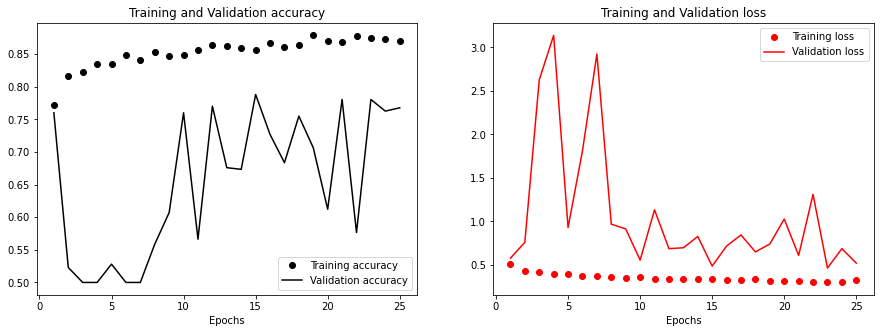

In [32]:
plot_results(history)

## ResNet50: Unfreeze top 2 blocks

In [45]:
# unfreeze
for layer in res_model.layers[:155]:
    layer.trainable = False
for layer in res_model.layers[155:]:
    layer.trainable = True

In [47]:
# run model
model.compile(loss='binary_crossentropy',
   optimizer='adam',
   metrics=['accuracy'])

history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=25,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        max_queue_size=30,
)

Epoch 1/25
48/48 [==============================] - 40s 749ms/step - loss: 0.5636 - accuracy: 0.7582 - val_loss: 0.8886 - val_accuracy: 0.5000
Epoch 2/25
48/48 [==============================] - 33s 688ms/step - loss: 0.4452 - accuracy: 0.8101 - val_loss: 1.1260 - val_accuracy: 0.5000
Epoch 3/25
48/48 [==============================] - 32s 683ms/step - loss: 0.4344 - accuracy: 0.8104 - val_loss: 2.0148 - val_accuracy: 0.5000
Epoch 4/25
48/48 [==============================] - 32s 667ms/step - loss: 0.3984 - accuracy: 0.8345 - val_loss: 2.2335 - val_accuracy: 0.5000
Epoch 5/25
48/48 [==============================] - 32s 660ms/step - loss: 0.3772 - accuracy: 0.8359 - val_loss: 2.3624 - val_accuracy: 0.5000
Epoch 6/25
48/48 [==============================] - 32s 660ms/step - loss: 0.3663 - accuracy: 0.8438 - val_loss: 2.0427 - val_accuracy: 0.5000
Epoch 7/25
48/48 [==============================] - 32s 657ms/step - loss: 0.3607 - accuracy: 0.8475 - val_loss: 2.1393 - val_accuracy: 0.5000

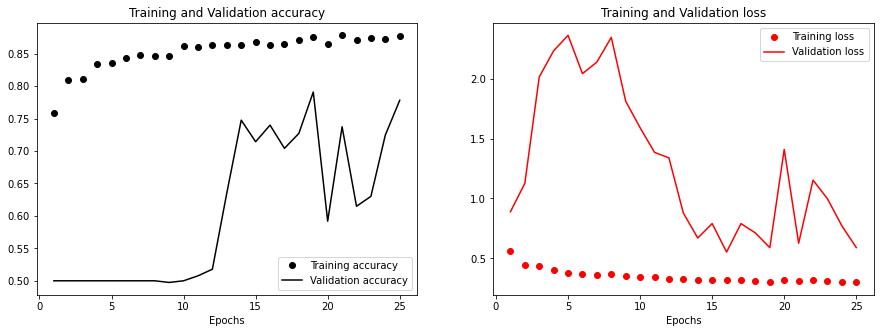

In [48]:
plot_results(history)

## ResNet50: Unfreeze top 3 blocks

In [46]:
for i, layer in enumerate(res_model.layers):
    print(i, layer.name, layer.trainable)

0 input_4 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [49]:
# unfreeze
for layer in res_model.layers[:143]:
    layer.trainable = False
for layer in res_model.layers[143:]:
    layer.trainable = True

In [50]:
# run model
model.compile(loss='binary_crossentropy',
   optimizer='adam',
   metrics=['accuracy'])

history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=25,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        max_queue_size=30,
)

Epoch 1/25
48/48 [==============================] - 36s 689ms/step - loss: 0.5309 - accuracy: 0.7681 - val_loss: 3.0662 - val_accuracy: 0.5000
Epoch 2/25
48/48 [==============================] - 32s 664ms/step - loss: 0.4192 - accuracy: 0.8169 - val_loss: 3.3268 - val_accuracy: 0.5000
Epoch 3/25
48/48 [==============================] - 32s 659ms/step - loss: 0.4020 - accuracy: 0.8234 - val_loss: 3.5675 - val_accuracy: 0.5000
Epoch 4/25
48/48 [==============================] - 32s 667ms/step - loss: 0.3844 - accuracy: 0.8353 - val_loss: 3.4136 - val_accuracy: 0.5000
Epoch 5/25
48/48 [==============================] - 32s 670ms/step - loss: 0.3657 - accuracy: 0.8438 - val_loss: 3.3310 - val_accuracy: 0.5000
Epoch 6/25
48/48 [==============================] - 32s 660ms/step - loss: 0.3374 - accuracy: 0.8569 - val_loss: 2.4718 - val_accuracy: 0.5000
Epoch 7/25
48/48 [==============================] - 32s 667ms/step - loss: 0.3609 - accuracy: 0.8546 - val_loss: 1.4774 - val_accuracy: 0.5128

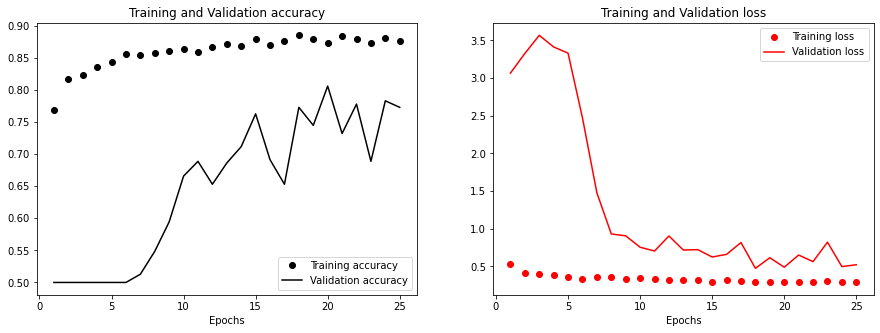

In [51]:
plot_results(history)

# Results And Discussion

VGG16 without fine tuning did better than 1.25 x PCC which is 65%. We can see that it reached around 85% accuracy or more. When fine tuning was done by unfreezing Conv block 5, the accuracy increased to around 91%.

For ResNet50, using the model without fine tuning gave at most around 77% accuracy, which was lower than the VGG16. Fine tuning was then done by unfreezing `conv5_block3`, which is the top 1 block which handles more specific features for the classification task at hand. Unfreezing this allows us to “repurpose” the model for our specific task. The accuracy here improved slightly as seen in the plot, reaching around 78%. Fine tuning by unfreezing the top 2 blocks resulted in the accuracy improving and reaching around 79%. Fine tuning further by unfreezing the top 3 blocks resulted in another improvement of accuracy, reaching around 80%. 

# Key Takeaways
1. VGG16 performs better on this dataset compared to ResNet50.
2. ResNet50 accuracy improves after unfreezing top 3 blocks.
3. Increasing the number of images in the dataset improved the performance of both VGG16 and ResNet50.

# References

[1] Valdenegro-Toro, M. (2016, December 1). Submerged marine debris detection with autonomous underwater vehicles. IEEE Xplore. https://doi.org/10.1109/RAHA.2016.7931907

[2] Moorton, Z., Kurt, Z., & Woo, W. (n.d.). Is the use of Deep Learning and Artificial Intelligence an appropriate means to locate debris in the ocean without harming aquatic wildlife? Retrieved March 11, 2022, from https://arxiv.org/pdf/2112.00190.pdf

[3] Tata, G. (2022, January 25). gautamtata/DeepPlastic. GitHub. https://github.com/gautamtata/DeepPlastic

[4] Ruiz-Frau, A., Hintz, H., & Jennings, C. (2019, November 11). Jellyfish dataset. Zenodo; Zenodo. https://zenodo.org/record/3545785#.Yh-gc-5BxJU

[5] images.cv | Image datasets for computer vision and machine learning. (n.d.). Images.cv. Retrieved March 11, 2022, from https://images.cv/dataset/jellyfish-image-classification-dataset